### Skill in predictands
Average temperature exceedence as a matched frame trough comparison framework + (model)climatology. Hotdays (also from a matched frame) not easily possible because multiple day thre
* Binary predictands
* Comparison of different aggregations. In terms of skill and in terms of rank histogram calibratrion.
* Benchmarks against trend model, raw forecasts, constant climatology.

In [1]:
import sys
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

from observations import Climatology
from forecasts import ModelClimatology
from comparison import ForecastToObsAlignment, Comparison

sys.path.append(os.path.expanduser('~/Documents/Weave'))
from Weave.models import BaseExceedenceModel # This is a subclass of sklearn.linear_model.LogisticRegression
from Weave.utils import reliability_plot
sys.path.append(os.path.expanduser('~/Documents/Hybrid'))
from Hybrid.dataprep import binarize_hotday_predictand

In [2]:
predictands = pd.DataFrame({'obs':['tg-anom_1998-06-07_2019-10-31_7D-roll-mean_15-t2m-q095-adapted-mean',
                                    'tg-anom_1998-06-07_2019-10-31_14D-roll-mean_15-t2m-q095-adapted-mean',
                                   'tg-anom_1998-06-07_2019-10-31_21D-roll-mean_15-t2m-q095-adapted-mean',
                                    'tg-anom_1998-06-07_2019-10-31_7D-roll-mean_0.58-t2m-q075-mean',
                                   'tg-anom_1998-06-07_2019-10-31_31D-roll-mean_15-t2m-q095-adapted-mean',
                                   'tg-ex-q0.75-21D_1998-06-07_2019-10-31_1D_15-t2m-q095-adapted-mean.nc',
                                   'tg-ex-q0.75-21D_1998-06-07_2019-10-31_1D_0.01-t2m-grid-mean.nc',
                                   'tg-ex-q0.75-14D_1998-06-07_2019-10-31_1D_15-t2m-q095-adapted-mean.nc',
                                   'tg-ex-q0.75-7D_1998-06-07_2019-08-31_1D_15-t2m-q095-adapted-mean.nc'],
                            'clim':['tg-anom_clim_1998-06-07_2019-10-31_7D-roll-mean_15-t2m-q095-adapted-mean_5_5_q0.75', # Do not suffer from missing model records
                                    'tg-anom_clim_1998-06-07_2019-10-31_14D-roll-mean_15-t2m-q095-adapted-mean_5_5_q0.75',
                                    'tg-anom_clim_1998-06-07_2019-10-31_21D-roll-mean_15-t2m-q095-adapted-mean_15_15_q0.9',
                                    'tg-anom_clim_1998-06-07_2019-10-31_7D-roll-mean_0.58-t2m-q075-mean_5_5_q0.75',
                                    'tg-anom_clim_1998-06-07_2019-10-31_31D-roll-mean_15-t2m-q095-adapted-mean_15_15_q0.75',
                                   None,None,None,None],
                            'books':['books_paper3-1_tg-anom_JJA_45r1_7D-roll-mean_15-t2m-q095-adapted-mean.csv',
                                     'books_paper3-1_tg-anom_JJA_45r1_14D-roll-mean_15-t2m-q095-adapted-mean.csv',
                                     'books_paper3-1_tg-anom_JJA_45r1_21D-roll-mean_15-t2m-q095-adapted-mean.csv',
                                     'books_paper3-1_tg-anom_JJA_45r1_7D-roll-mean_0.58-t2m-q075-mean.csv',
                                     'books_paper3-1_tg-anom_JJA_45r1_31D-roll-mean_15-t2m-q095-adapted-mean.csv',
                                    'books_paper3-2_tg-ex-q0.75-21D_JJA_45r1_1D_15-t2m-q095-adapted-mean.csv',
                                    'books_paper3-2_tg-ex-q0.75-21D_JJA_45r1_1D_0.01-t2m-grid-mean.csv',
                                    'books_paper3-2_tg-ex-q0.75-14D_JJA_45r1_1D_15-t2m-q095-adapted-mean.csv', # The 14D and 7D still based on old highresmodelclim?
                                    'books_paper3-2_tg-ex-q0.75-7D_JJA_45r1_1D_15-t2m-q095-adapted-mean.csv'],
                             'modelclim':['tg-anom_45r1_1998-06-07_2019-10-31_7D-roll-mean_15-t2m-q095-adapted-mean_5_5_q0.75', # These modelclims are also old.
                                          'tg-anom_45r1_1998-06-07_2019-10-31_14D-roll-mean_15-t2m-q095-adapted-mean_5_5_q0.75',
                                          'tg-anom_45r1_1998-06-07_2019-08-31_21D-roll-mean_15-t2m-q095-adapted-mean_15_15_q0.9', # This is not old.
                                          'tg-anom_45r1_1998-06-07_2019-10-31_7D-roll-mean_0.58-t2m-q075-mean_5_5_q0.75',
                                          'tg-anom_45r1_1998-06-07_2019-08-31_31D-roll-mean_15-t2m-q095-adapted-mean_15_15_q0.75', # This is not old. Also 0.5 is available
                                         None,None,None,None], # These do use daily climatologies though.
                            },
                           index = pd.Index(['tg7D','tg14D','tg21D','tg7Dhighres','tg31D','tgex21D','tgex21Dhighres','tgex14D','tgex7D'], name = 'basevar'))

In [3]:
def add_trend_model(df, groupers = ['leadtime','clustid'], return_coefs = True):
    """
    Modifies the dataframe inplace, adding a trend column 
    This can involve multiple logistic regressions. namely one for a series with a unique time_index.
    Determined by groupers. Pooling (non-grouping) leadtime might be possible, 
    but still needs unique time for reindex
    """
    indexed_df = df.set_index(groupers + ['time'])
    groupeddf = indexed_df.groupby(groupers)
    coefs = []
    intercepts = []
    predictions = []
    keys = []
    for key, subdf in groupeddf:
        model = BaseExceedenceModel()
        model.fit(X = subdf, y = subdf[('observation',0)]) # Extracts and normalizes the timeindex from X
        predictions.append(pd.Series(model.predict(X = subdf), index = subdf.index , name = 'trend'))
        coefs.append(model.coef_[0][0])
        intercepts.append(model.intercept_[0])
        keys.append(key)
    predictions = pd.concat(predictions, axis = 0).reindex(indexed_df.index) # Should be the same order now as the non-indexed df
    df['trend'] = predictions.values
    if return_coefs:
        logreg_results = pd.DataFrame({'coef':coefs, 'intercept':intercepts}, index = pd.MultiIndex.from_tuples(keys, names = groupers))
        return logreg_results

def load(booksname: str, compute = False):
    al = ForecastToObsAlignment('JJA','45r1')
    al.recollect(booksname = booksname)
    if compute:
        return(al.alignedobject.compute())
    else:
        return al
    
def load_tganom_and_compute(bookfile: str, climname: str, modelclim: str = None, add_trend: bool = True, return_trend: bool = False):
    al = load(booksname = bookfile, compute = False)
    cl = Climatology('tg-anom', name = climname)
    cl.localclim()
    if not modelclim is None:
        mcl = ModelClimatology('45r1','tg', **{'name':modelclim})
        mcl.local_clim()
    else:
        mcl = None
    comp = Comparison(al, climatology = cl, modelclimatology = mcl)
    comp.brierscore() # Transforms the observations in exceedences. Needed for trend model. 
    df = comp.frame.compute()
    if add_trend:
        coefs = add_trend_model(df = df, groupers = ['leadtime','clustid'], return_coefs=return_trend)
        df['trend_bs'] = (df['trend'].values.squeeze() - df['observation'].values.squeeze())**2
    df = df.set_index(['time','leadtime','clustid'])
    if return_trend:
        return df, coefs
    else:
        return df

def load_tgex_and_compute(bookfile: str, nday_threshold: int = 3, add_trend: bool = True, return_clim_freq: bool = False, return_trend: bool = False):
    """
    A computed aligned frame. returns it with a pi, pi_bs and clim_bs column. 
    Pi is for positive case so chance of >= nday_threshold
    possible to return the fitted logistic coefficients
    possible to return frequencies (these are namely not constant over clustids like with tganom > quantile)
    """
    test = load(booksname = bookfile, compute = True)
    test['pi'] = binarize_hotday_predictand(test['forecast'], ndaythreshold = nday_threshold) # Uses Tukey
    test['observation'] = binarize_hotday_predictand(test[('observation',0)], ndaythreshold = nday_threshold)
    clim_chances = test.groupby('clustid').mean()['observation'] # Assume there is little leadtime dependence (pooling these for a smoother estimate)
    clim_chances.columns = pd.MultiIndex.from_tuples([('climatology','')])
    test = test.merge(clim_chances, on = 'clustid')
    if add_trend:
        coefs = add_trend_model(df = test, groupers = ['leadtime','clustid'], return_coefs=return_trend) # happens inplace
    for key in ['pi','climatology','trend']:
        if key in test.columns:
            bs = (test[key].values.squeeze() - test['observation'].values.squeeze())**2
            scorename = f'{key}_bs'
            test[scorename] = bs
    test = test.set_index(['time','leadtime','clustid'])
    returns = (test,)
    if return_clim_freq:
        returns = returns + (clim_chances,)
    if return_trend: # potentially already a tuple
        returns = returns + (coefs,)
    if len(returns) == 1:
        return returns[0]
    else:
        return returns

def compute_bss(df: pd.DataFrame):
    mean_bs = df.groupby(['leadtime','clustid']).mean() # Mean over time
    mean_bs.columns = mean_bs.columns.droplevel('number')
    mean_bs['bss_fix'] = 1 - mean_bs['pi_bs'] / mean_bs['climatology_bs']
    if 'trend_bs' in mean_bs.columns:
        mean_bs['bss_trend'] = 1 - mean_bs['pi_bs'] / mean_bs['trend_bs']
        return mean_bs[['bss_fix','bss_trend']]
    else:
        return mean_bs[['bss_fix']]

def compute_skill_horizon(scoredf):
    """
    Pretty rough because variability in the score is not really accounted for.
    Score df can have multiple columns but should be indexed with clustid and leadtime
    returns per clustid and score column the leadtime at which it drops below zero.
    """
    below = scoredf < 0
    grouped = below.groupby(['clustid'])
    def single_column_horizon(onescore):
        """ Boolean indexed by leadtime only """
        incr_leadtime = onescore.sort_index()
        indices_of_below = incr_leadtime.values.squeeze().nonzero()[0]
        if indices_of_below.size == 0: # Empty, none is below
            first_below = incr_leadtime.values.size - 1 # horizon will be the final leadtime
        else:
            first_below = indices_of_below.min()
        return incr_leadtime.index.get_level_values('leadtime')[first_below]
    return grouped.apply(lambda multicol: multicol.apply(single_column_horizon, axis = 0))

def compute_frequency_mismatch(df: pd.DataFrame):
    """ For binary predictands (hotdays after thresholding) """
    extract = df[['observation','climatology','pi','clustid','leadtime']].copy()
    extract.loc[:,'freqdiff'] = df['pi'] - df[('climatology','')] # Could also be done with - observation. Pretty equivalent after averaging.
    return extract.groupby(['leadtime','clustid']).mean()['freqdiff']


"""
Non binary investigation
"""
def load_compute_rank(bookfile: str, return_bias: bool = False):
    """
    Continous evaluation. Should not matter whether it is somewhat discrete, like the count of hotday exceedences.
    Actually multiple rank hists are possible, namely per leadtime and per clustid.
    Therefore returns an indexed dataframe. From which the desired 
    Option to return the bias between ensemble mean and observation
    """
    frame = load(booksname = bookfile, compute = True)
    n_members = frame['forecast'].shape[-1]
    noisy_for = frame['forecast'].values + np.random.normal(scale = 0.001, size = frame['forecast'].shape)
    noisy_obs = frame['observation'].values + np.random.normal(scale = 0.001, size = frame['observation'].shape)
    n_higher = (noisy_for > noisy_obs).sum(axis = 1)
    frame['placement'] = (-n_higher) + n_members + 1 # placement in the order. if 0 higher than place n+1,
    bin_edges = np.arange(1 - 0.5, n_members + 1 + 1 + 0.5) # from min (1) to max (12) + 1, both +- 0.5. Max is plus 2 because of np.arange non-inclusive stops
    frame = frame.set_index(['leadtime','clustid','time'])
    if 'number' in frame.columns.names:
        frame.columns = frame.columns.droplevel('number')
    if not return_bias:
        return frame['placement'], bin_edges
    else:
        frame.loc[:,'bias'] = frame['forecast'].mean(axis = 1) - frame['observation'] #bias between ensmean - obs 
        #frame.loc[:,'meanbias'] = (frame['forecast'].values - frame['observation'].values[:,np.newaxis]).mean(axis = 1) # bias as mean(members - obs). completely equivalent
        return frame[['placement','bias']], bin_edges

def bootstrap_rank_hist(bookfile:str, leadtime: int, clustid: int = 9, nsamples:int = 100):
    # 12 places, build a matrix suitable for boxplots 
    counts = np.zeros((nsamples,12), dtype = np.int32)
    for i in range(nsamples):
        placement, bins = load_compute_rank(bookfile = bookfile, return_bias = False)
        vals, count = np.unique(placement.loc[(leadtime,clustid)], return_counts = True)
        assert len(count) == 12, 'Empty rank histogram spots, are you sampling enough data?'
        counts[i,:] = count
    labels = vals
    return counts, labels 
        

def autocorrelation(bookfile: str):
    """
    Computation of auto-correlation, for investigating persistence.
    Requires 2D rolling. Currently a bit complicated.
    """
    al = ForecastToObsAlignment('JJA','45r1')
    al.recollect(booksname = bookfile)
    frame = al.alignedobject.compute()
    pass

"""
General functions.
"""
def lineplot(df: pd.DataFrame, freqframe: pd.DataFrame = None, plotkwargs: dict = {}, zeroline: bool = True):
    """
    plots a leadtime,clustid-indexed frame. Plus optional frequencies in the legend per clustid
    If a subset of columns (or clustids) is desired, .loc select those beforehand
    """
    plotframe = df.unstack('clustid')
    if 'number' in plotframe.columns.names:
        plotframe.columns = plotframe.column.droplevel('number')
    if not freqframe is None:
        freqs = freqframe.loc[plotframe.columns.get_level_values('clustid'),:].iloc[:,0].round(2).values
        oldcols = plotframe.columns.to_frame()
        plotframe.columns = pd.MultiIndex.from_frame(oldcols.assign(frequency = freqs))
    fig, ax = plt.subplots()
    if zeroline:
        ax.hlines(0,plotframe.index.min(),plotframe.index.max(), color = 'grey')
    plotframe.plot(ax = ax, **plotkwargs)
    return fig, ax

### Properties of the predictands
Leadtime here is not separation.

In [84]:
fr = load(booksname = predictands.loc['tgex21D','books'], compute = True)
fr = fr.iloc[fr['clustid'].values == 9,:]

Text(0.5, 0, 'number of days >q0.75 in 21-day period')

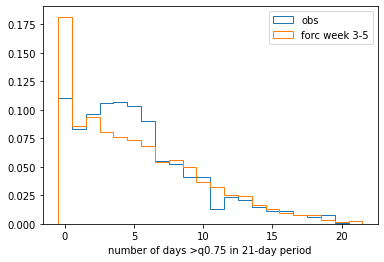

In [85]:
bins = np.arange(-0.5,22.5,1)
fig, ax = plt.subplots()
ax.hist(fr[('observation',0)], bins = bins, histtype = 'step', density = True, label = 'obs')
#ax.hist(fr.loc[fr['leadtime'].values == 1,'forecast'].stack('number'), bins = bins, histtype = 'step', density = True, label = 'forc week 1-3')
ax.hist(fr.loc[fr['leadtime'].values == 15,'forecast'].stack('number'), bins = bins, histtype = 'step', density = True, label = 'forc week 3-5')
ax.legend()
ax.set_xlabel('number of days >q0.75 in 21-day period')

<AxesSubplot:xlabel='time'>

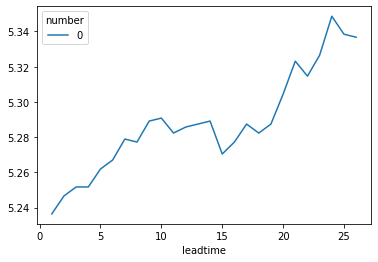

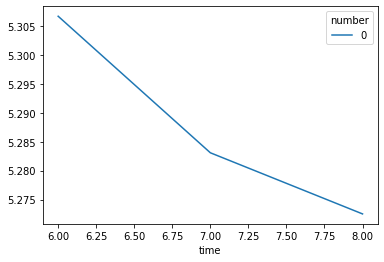

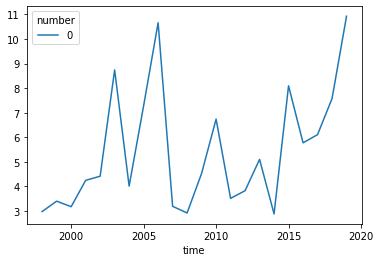

In [6]:
fr = load(booksname = predictands.loc['tgex21D','books'], compute = True)
fr = fr.iloc[fr['clustid'].values == 9,:]
stats = fr.set_index(['time','leadtime'])
stats.groupby('leadtime').mean()['observation'].plot()
stats.groupby(stats.index.get_level_values('time').month).mean()['observation'].plot()
stats.groupby(stats.index.get_level_values('time').year).mean()['observation'].plot()

In [15]:
tg21ex, tgex_bins = load_compute_rank(bookfile = predictands.loc['tgex21D','books'], return_bias=False)
tg21, tg21_bins = load_compute_rank(bookfile = predictands.loc['tgex21D','books'], return_bias=True)

In [86]:
#ranklead1, labels = bootstrap_rank_hist(bookfile = predictands.loc['tgex21D','books'], leadtime = 1, nsamples = 500)
ranklead15, labels = bootstrap_rank_hist(bookfile = predictands.loc['tgex21D','books'], leadtime = 15, nsamples = 500)

/tmp/ipykernel_1553008/3624757578.py:155: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals, count = np.unique(placement.loc[(leadtime,clustid)], return_counts = True)


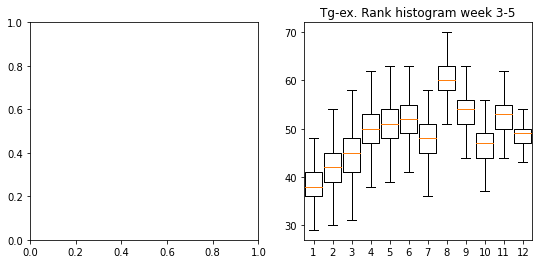

In [87]:
fig, axes = plt.subplots(ncols = 2, figsize = (9,4))
#axes[0].boxplot(ranklead1, labels = labels, showfliers = False, widths = 0.9)
#ax.plot(labels,np.median(test, axis = 0))
#axes[0].set_title('Rank histogram week 1-3')
axes[1].boxplot(ranklead15, labels = labels, showfliers = False, widths = 0.9)
axes[1].set_title('Tg-ex. Rank histogram week 3-5')
plt.show()

In [52]:
ranklead25, labels = bootstrap_rank_hist(bookfile = predictands.loc['tgex21D','books'], leadtime = 25, nsamples = 500)

/tmp/ipykernel_2106756/3425782278.py:153: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals, count = np.unique(placement.loc[(leadtime,clustid)], return_counts = True)


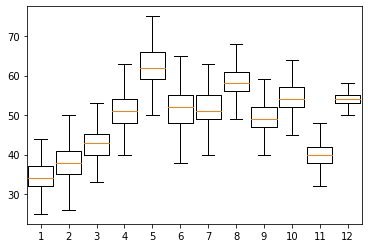

In [54]:
fig, ax = plt.subplots(ncols = 1)
ax.boxplot(ranklead25, labels = labels, showfliers = False, widths = 0.9)
plt.show()

array([[<AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'15'}>]], dtype=object)

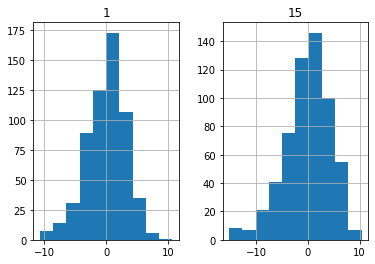

In [40]:
tg21ex.loc[([1,15],9),'bias'].unstack('leadtime').hist()

Text(0, 0.5, 'bias (ensmean - observation)')

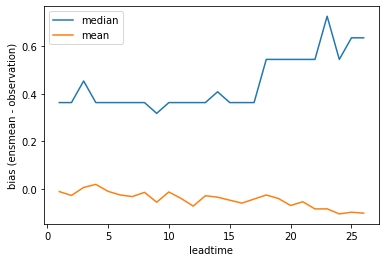

In [42]:
ax = tg21ex.loc[(slice(None),9),'bias'].groupby('leadtime').median().plot(label = 'median')
tg21ex.loc[(slice(None),9),'bias'].groupby('leadtime').mean().plot(ax = ax, label = 'mean')
ax.legend()
ax.set_ylabel('bias (ensmean - observation)')

* The many cases/members with zero hot days is consistent with the model underestimation (cold bias?) that is visible in the rank histograms (model often in the upper tail).
* The weird blip at position 1 in the rank histogram leadtime 1 seems to be a case of underdispersion.
* In the median case the ensemble mean is positively biased. most prominent at longest leadtimes (there also in combination with underdispersion though, this underdispersion is most striking at the negative end).

In [132]:
ranktganom15, labels = bootstrap_rank_hist(bookfile = predictands.loc['tg21D','books'], leadtime = 1, nsamples = 500)

/tmp/ipykernel_1553008/3624757578.py:155: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals, count = np.unique(placement.loc[(leadtime,clustid)], return_counts = True)


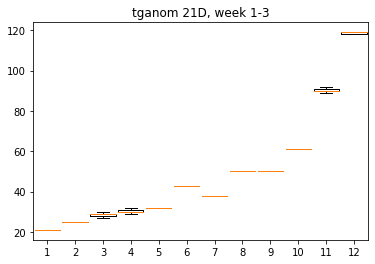

In [133]:
fig, ax = plt.subplots(ncols = 1)
ax.boxplot(ranktganom15, labels = labels, showfliers = False, widths = 0.9)
ax.set_title('tganom 21D, week 1-3')
plt.show()

* The mean temperature is obviously biased. Perhaps more so than the amount of hotdays.

Check reliability for a similar extremity

In [4]:
frame21tganom = load_tganom_and_compute(bookfile = predictands.loc['tg21D','books'], climname = predictands.loc['tg21D','clim'], modelclim= predictands.loc['tg21D','modelclim'], return_trend = False)
frame21tgex = load_tgex_and_compute(bookfile = predictands.loc['tgex21D','books'], nday_threshold = 12, return_trend=False)

climatology directly loaded
climatology directly loaded


/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


lazy pi and bool observation construction


/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Hybrid/Hybrid/dataprep.py:40: UserWarning: using alpha 0.3333333333333333 for forecast categorization
  warnings.warn(f'using alpha {alpha} for forecast categorization')
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your pro

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

In [91]:
clustid = 10
leadtime = 15
tganomsubset = frame21tganom.loc[(slice(None),leadtime,clustid),['observation','pi','trend']]
tganomsubset.columns = tganomsubset.columns.droplevel('number')
tgexsubset = frame21tgex.loc[(slice(None),leadtime,clustid),['observation','pi','trend']]
tgexsubset.columns = tgexsubset.columns.droplevel('number')
tgexsubset = tgexsubset.reindex_like(tganomsubset)
plotframe = pd.concat([tganomsubset, tgexsubset],axis =1 , keys = ['tg21D > q0.9','tgex21D > 12D'])
plotframe.columns.names = ['variable','type']

Text(0.5, 1.0, 'week 3-5')

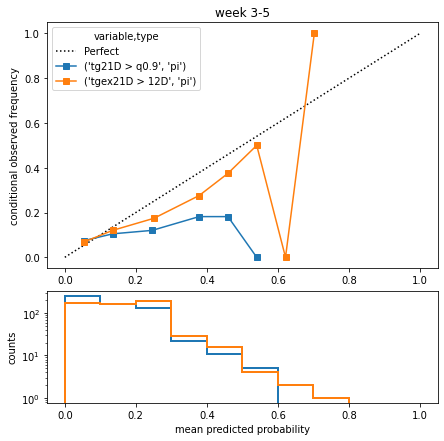

In [92]:
fig, axes = reliability_plot(plotframe.loc[:,(slice(None),'observation')], plotframe.loc[:,(slice(None),'pi')])
axes[0].set_title('week 3-5')

Check the brier scores.

In [87]:
leadtime = 1
bs = frame21tganom.loc[(slice(None),leadtime, clustid),['pi_bs','trend_bs']].mean(axis = 0)
print(1 - bs['pi_bs']/bs['trend_bs'])

number
    0.360154
dtype: float64


In [88]:
bs = frame21tgex.loc[(slice(None),leadtime, clustid),['pi_bs','trend_bs']].mean(axis = 0)
print(1 - bs['pi_bs']/bs['trend_bs'])

number
    0.310174
dtype: float64


##### investigation of ensemble mean bias.
Not really insightful

In [34]:
fr[('ensmean',0)] = fr['forecast'].mean(axis = 1)

Text(0.5, 1.0, 'all leadtimes')

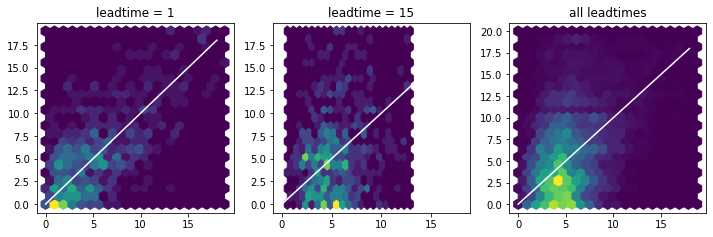

In [74]:
f1 = fr.loc[fr['leadtime'].values == 1,:]
f15 = fr.loc[fr['leadtime'].values == 15,:]
fig, axes = plt.subplots(nrows = 1, ncols = 3 , squeeze = False, figsize = (12,3.5))
axes[0,0].hexbin(f1['ensmean'], f1[('observation',0)], gridsize = 20)
axes[0,0].plot([0,18],[0,18], color = 'white')
axes[0,0].set_title('leadtime = 1')
axes[0,1].hexbin(f15['ensmean'], f15[('observation',0)], gridsize = 20)
axes[0,1].plot([0,18],[0,18], color = 'white')
axes[0,1].set_title('leadtime = 15')
axes[0,2].hexbin(fr['ensmean'], fr[('observation',0)], gridsize = 20)
axes[0,2].plot([0,18],[0,18], color = 'white')
axes[0,2].set_title('all leadtimes')

In [84]:
memberbias = pd.DataFrame(fr['forecast'].values - fr[('observation',0)].values[:,np.newaxis], index = pd.MultiIndex.from_frame(fr[['time','leadtime']], names = ['time','leadtime']))
memberbias = memberbias.stack()
memberbias.name = 'memberbias'
member = pd.DataFrame(fr['forecast'].values,  index = pd.MultiIndex.from_frame(fr[['time','leadtime']], names = ['time','leadtime']))
member = member.stack()
member.name = 'member'
total = pd.concat([member, memberbias], axis = 1)

obs = fr['observation']
obs.index = pd.MultiIndex.from_frame(fr[['time','leadtime']], names = ['time','leadtime'])
obs.columns = pd.Index(['obs'])
joint = pd.merge(total,obs, on = ['time','leadtime'])

Text(0.5, 1.0, 'all leadtimes')

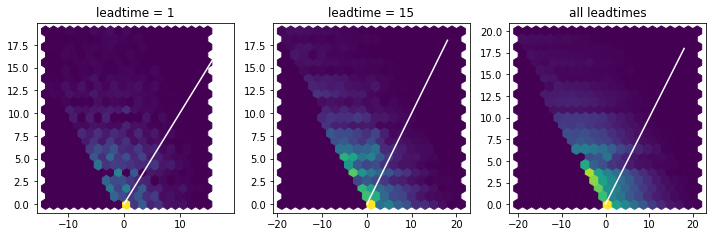

In [87]:
fig, axes = plt.subplots(nrows = 1, ncols = 3 , squeeze = False, figsize = (12,3.5))
axes[0,0].hexbin(joint.loc[(slice(None),1),'memberbias'], joint.loc[(slice(None),1),'obs'], gridsize = 20)
axes[0,0].plot([0,18],[0,18], color = 'white')
axes[0,0].set_title('leadtime = 1')
axes[0,1].hexbin(joint.loc[(slice(None),15),'memberbias'], joint.loc[(slice(None),15),'obs'], gridsize = 20)
axes[0,1].plot([0,18],[0,18], color = 'white')
axes[0,1].set_title('leadtime = 15')
axes[0,2].hexbin(joint.loc[:,'memberbias'], joint.loc[:,'obs'], gridsize = 20)
axes[0,2].plot([0,18],[0,18], color = 'white')
axes[0,2].set_title('all leadtimes')

### Cross comparing regions and predictands

#### Time aggregation and spatial aggregation in tg-anom
Comparing 14 day with 7 day in large spatial regions. And comparing 7 in large spatial regions with 7day in smaller spatial regions. Exceedence pi (tukey) is not computed with a dedicated modelclimatology

In [7]:
frame, coefs31 = load_tganom_and_compute(bookfile = predictands.loc['tg31D','books'], climname = predictands.loc['tg31D','clim'], return_trend = True)
bss31 = compute_bss(frame)
horizons31 = compute_skill_horizon(bss31)

climatology directly loaded
lazy pi and bool observation construction


/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/stra

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

In [8]:
frame, coefs14 = load_tganom_and_compute(bookfile = predictands.loc['tg14D','books'], climname = predictands.loc['tg14D','clim'], return_trend = True)
bss14 = compute_bss(frame)
horizons14 = compute_skill_horizon(bss14)

climatology directly loaded
lazy pi and bool observation construction


/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/stra

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

In [9]:
frame, coefs7 = load_tganom_and_compute(bookfile = predictands.loc['tg7D','books'], climname = predictands.loc['tg7D','clim'], return_trend = True)
bss7 = compute_bss(frame)
horizons7 = compute_skill_horizon(bss7)

climatology directly loaded
lazy pi and bool observation construction


/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/stra

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [10]:
horizons14

,bss_fix,bss_trend
clustid,,
0,11,8
1,11,11
2,12,11
3,12,12
4,17,12
5,20,14
6,20,17
7,10,9
8,25,25


So of the non-islands (6 and 8 are islands. Azores = 8, Madeira = 6. and have a large extended horizon)
Larger differences above between the fix and the trend means that the predictand is pretty trended. Which we can see in the coefficients below. Also it is visible that the size of coefficients and influence of the trend on extended skill is higher for the more aggregated 14day target.

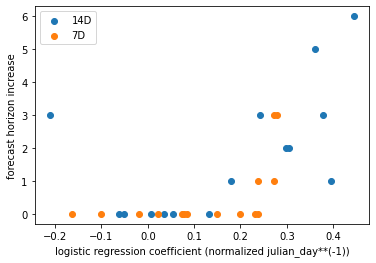

In [197]:
plt.scatter(x = coefs14.groupby('clustid').mean()['coef'], y = horizons14['bss_fix'] - horizons14['bss_trend'], label = '14D')
plt.scatter(x = coefs7.groupby('clustid').mean()['coef'], y = horizons7['bss_fix'] - horizons7['bss_trend'], label = '7D')
plt.ylabel('forecast horizon increase')
plt.xlabel('logistic regression coefficient (normalized julian_day**(-1))')
plt.legend()
plt.show()

Investigating the benefit of lengthening aggregation from 7 to 14 days, for the same clusters, we see that overall it is not really beneficial, except for 9 and 8 (Perhaps not long enough, or perhaps this has to do with averaging, and needing to get more correct within the bounds).
For lengthening from 14 days to 31 days, we see that the forecast horizon is always decreased. One reason is that it has a maximum of 16 days. But also that is not always attained in terms of BSS_fix.

In [180]:
horizons14 - horizons7

,bss_fix,bss_trend
clustid,,
0,-4,-6
1,0,0
2,-3,-4
3,-1,-1
4,-1,-3
5,1,-2
6,0,-3
7,-2,-3
8,1,1


In [23]:
horizons31 - horizons14

,bss_fix,bss_trend
clustid,,
0,4,-2
1,-3,-6
2,-6,-5
3,-6,-6
4,-7,-6
5,-5,-11
6,-4,-2
7,0,-6
8,-9,-9


Some investigation of one predictand only. Despite being regionally averaged we see a consitent negative bias. (observation of lies outside the positive tail often). The consistency shows over leadtimes (though lessening a bit) and over regions. Switching betweem 7 or 14-Day or 31-Day does not make a difference (though perhaps a bit less severe in 14day, because variability is also less?). Of course part of the negative bias is just representativity of the resolution.  (for binary exceedence this is probably somewhat corrected by using a modelclimatology).

In [254]:
ranks, rankbins = load_compute_rank(bookfile = predictands.loc['tg14D','books'], return_bias = True)

array([[<AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'8'}>],
       [<AxesSubplot:title={'center':'9'}>,
        <AxesSubplot:title={'center':'10'}>]], dtype=object)

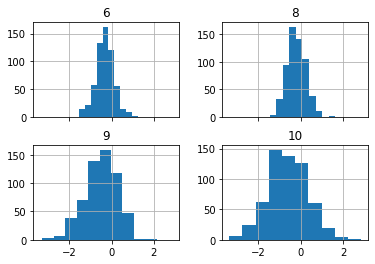

In [255]:
ranks.loc[(1,[6,8,9,10]),'bias'].unstack('clustid').hist(sharex = True)

array([[<AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'8'}>],
       [<AxesSubplot:title={'center':'9'}>,
        <AxesSubplot:title={'center':'10'}>]], dtype=object)

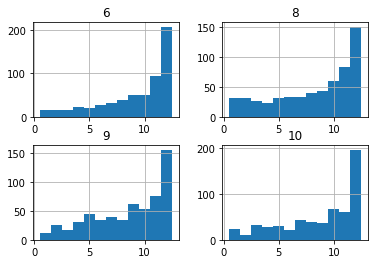

In [257]:
ranks.loc[(1,[6,8,9,10]),'placement'].unstack('clustid').hist(bins = rankbins)

array([[<AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'15'}>],
       [<AxesSubplot:title={'center':'21'}>,
        <AxesSubplot:title={'center':'32'}>]], dtype=object)

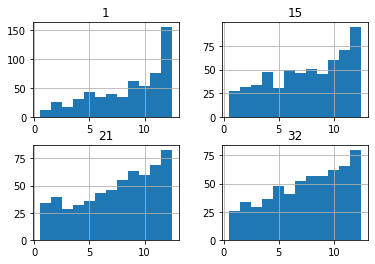

In [258]:
ranks.loc[([1,15,21,32],9),'placement'].unstack('leadtime').hist(bins = rankbins)

#### Spatial aggregation in the tg-anom 7D

Now the clustids do not match anymore. But selcting the ones in west/central europe there is not too much difference it seems.

In [266]:
frame, coefs7_highres = load_tganom_and_compute(bookfile = predictands.loc['tg7Dhighres','books'], climname = predictands.loc['tg7Dhighres','clim'], return_trend = True)
bss7_highres = compute_bss(frame)
horizons7_highres = compute_skill_horizon(bss7_highres)

climatology directly loaded
lazy pi and bool observation construction


/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/stra

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [269]:
horizons7.loc[[9,10]]

,bss_fix,bss_trend
clustid,,
9,15,14
10,16,16


In [270]:
horizons7_highres.loc[[20,23,25,27]]

,bss_fix,bss_trend
clustid,,
20,13,13
23,14,14
25,15,15
27,14,14


### Hotdays predictand

#### Spatial aggregation in hotdays
Lowres exceedence versus highres 21-day exceedence. Could be compared over for muliple nday_threshold settings. For now such that the occurrence is about 5% of the time. We see that the skill differs quite a lot for the different gridpoints. Trends are mostly significantly positive (so we expect bss_fix > bss_trend)

In [27]:
frame, freq, trend = load_tgex_and_compute(bookfile = predictands.loc['tgex21Dhighres','books'], nday_threshold = 15, add_trend = True, return_clim_freq=True, return_trend = True)
bss = compute_bss(frame)
horizon_highres = compute_skill_horizon(bss)

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/stra

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='leadtime'>)

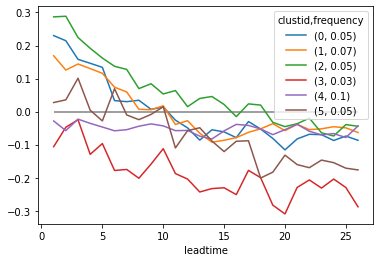

In [28]:
lineplot(bss['bss_trend'], freq)
#lineplot(trend['coef'])

2 (Germany) is the most skillful. We see that some points do not even achieve positive skill in the beginning. This is related to a mismatch in occurrence (Below). Interestingly we see two reasons to be off. Purple has more frequent ocurrence, but an underforcasting. Brown has a lower occurrence and an overforecasting. For the rarer thresholds there seem to be an overforecasting almost always. For low thresholds almost always an underforecasting (more frequent that forecast)

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='leadtime'>)

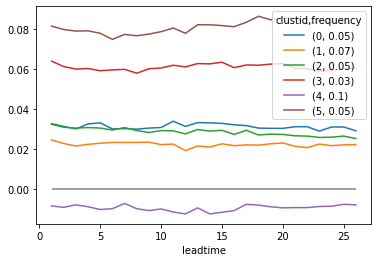

In [29]:
freqdiff = compute_frequency_mismatch(frame)
lineplot(freqdiff, freq)

In [16]:
frame, freq, trend = load_tgex_and_compute(bookfile = predictands.loc['tgex21D','books'], nday_threshold = 15, add_trend = True, return_clim_freq=True, return_trend = True)
bss = compute_bss(frame)
horizon = compute_skill_horizon(bss)

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/stra

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='leadtime'>)

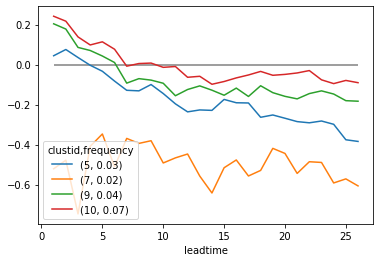

In [19]:
lineplot(bss.loc[(slice(None),[5,7,9,10]),'bss_trend'], freq)

In [20]:
horizon

,bss_fix,bss_trend
clustid,,
0,1,1
1,1,1
2,3,3
3,1,1
4,1,1
5,4,4
6,19,19
7,1,1
8,10,9


In [21]:
horizon_highres

,bss_fix,bss_trend
clustid,,
0,11,11
1,11,11
2,23,16
3,1,1
4,2,1
5,5,5


So in both lowres and highres you see occurrences of (biased) low skill tagets. But then the possibility of really extended skill also seems to be limited to the highres point. (6 and 8 in the low spatial res are also points)

#### Comparison of extremity in hotdays
Above we've investigated the 15day exceedence within a 21day period, which happens only between 3 and 10% of the time, depending on the local dependence. But we can check how the skill is a function of extremity. Highres exceedence actually gives a very interesting pattern (for the lower amount of hotdays there is hardly any forecast horizon.). That setting has a high amount of positive cases, and too little seem to be forecast. I.e. a cold bias making things to cold.

In [83]:
var = 'tgex21Dhighres'
horizons = {}
frequencies = {}
for i in range(1,17): # Beyond there are clusters with no positive cases.
    frame, freqs = load_tgex_and_compute(bookfile = predictands.loc[var,'books'], nday_threshold = i, add_trend = True, return_clim_freq=True)
    frequencies.update({i:freqs})
    bss = compute_bss(frame)
    horizons.update({i:compute_skill_horizon(bss)})

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/nobackup_1/user

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative de

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative de

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative de

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative de

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative de

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative de

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='ndaythreshold'>)

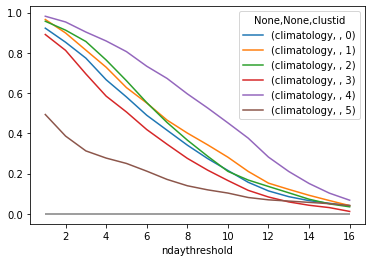

In [88]:
joined_freq = pd.concat(frequencies)
joined_freq.index.names = ['ndaythreshold', 'clustid']
lineplot(joined_freq)

The behaviour of cluster 5 here is very weird. Almost as if the daily threshold is imperfectly estimated (there should certainly be a considerable chance that more than one day of >q0.75 in the period, unless q0.75 is actually q0.99).

In [6]:
joined = pd.concat(horizons)
joined.index.names = ['ndaythreshold', 'clustid']
joined.unstack('clustid')['bss_trend']

clustid,0,1,2,3,4,5
ndaythreshold,,,,,,
1,1,1,1,5,1,1
2,3,1,1,6,1,1
3,3,1,1,9,1,1
4,7,1,1,10,1,3
5,8,5,2,9,1,7
6,9,7,3,9,1,6
7,11,8,7,12,1,5
8,12,9,9,12,1,4
9,12,11,13,11,1,7


For Cluster 2 we see more skill for nday_threshold > 12 (about 1/3 of the time positive), and less for nday_threshold < 5 (about 1/3 of the time negative). Which is interesting. In the ranks we see the same negative bias, often a higher amount than in the forecasts.

In [22]:
ranks, rankbins = load_compute_rank(bookfile = predictands.loc['tgex21Dhighres','books'], return_bias = True)

array([[<AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'9'}>],
       [<AxesSubplot:title={'center':'15'}>,
        <AxesSubplot:title={'center':'26'}>]], dtype=object)

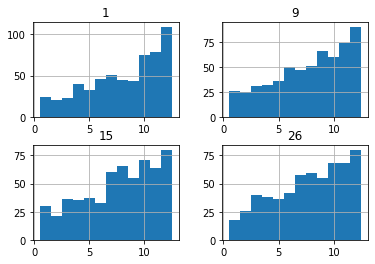

In [32]:
ranks.loc[([1,9,15,26],2),'placement'].unstack('leadtime').hist(bins = rankbins)

In [34]:
var = 'tgex21D'
horizons = {}
frequencies = {}
for i in range(1,17): # Beyond there are clusters with no positive cases.
    frame, freqs = load_tgex_and_compute(bookfile = predictands.loc[var,'books'], nday_threshold = i, add_trend = True, return_clim_freq=True)
    frequencies.update({i:freqs})
    bss = compute_bss(frame)
    horizons.update({i:compute_skill_horizon(bss)})

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/stra

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative de

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative de

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

In [36]:
joined = pd.concat(horizons)
joined.index.names = ['ndaythreshold', 'clustid']

In [37]:
joined.unstack('clustid')['bss_trend']

clustid,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
ndaythreshold,,,,,,,,,,,,,,,
1,5,6,3,10,10,14,15,9,6,1,13,6,5,3,7
2,5,12,8,11,12,15,25,10,7,4,15,8,7,6,6
3,6,17,8,14,13,22,26,10,10,6,15,8,8,7,7
4,7,13,9,12,13,22,26,13,14,6,13,9,9,9,6
5,10,13,12,9,12,18,23,10,22,12,13,11,10,21,6
6,7,9,12,7,8,17,23,11,23,14,13,14,11,26,10
7,5,4,14,6,7,17,24,11,25,9,12,16,10,26,8
8,4,1,11,6,7,18,21,10,26,13,13,12,9,26,5
9,3,1,11,5,6,15,20,11,26,14,14,9,9,26,4


### Reference for geographical location

In [141]:
basepath = Path('/nobackup/users/straaten/ERA5/')
clusterpath = basepath / 'tg-anom_1998-06-07_2019-10-31_7D-roll-mean_15-t2m-q095-adapted-mean.nc'

In [142]:
clusters = xr.open_dataset(clusterpath)['clustidfield']

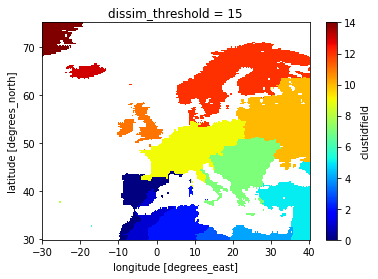

In [143]:
clusters.plot(cmap = 'jet')

cluster 6 and 8 are almost gridpoints. They actually are islands. Azores = 8, Madeira = 6.

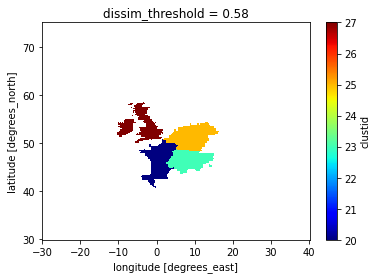

In [260]:
ids = [20,23,25,27]
clusters = xr.open_dataarray('/nobackup/users/straaten/clusters/t2m-q075.nc').sel(dissim_threshold = 0.58)
limited = clusters.where(clusters.isin(ids), np.nan)
limited.plot(cmap = 'jet')

### Checking the 14D tgex
This variable still uses the faulty highres modelclim with a gap in it and imperfect june estimates.
Graph looks very similar to old one (differences should only be because of tukey plotting position).

In [40]:
frame, freq, trend = load_tgex_and_compute(bookfile = predictands.loc['tgex14D','books'], nday_threshold = 12, add_trend = True, return_clim_freq=True, return_trend = True)
bss = compute_bss(frame)

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/stra

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='leadtime'>)

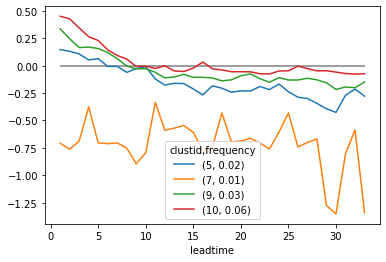

In [43]:
lineplot(bss.loc[(slice(None),[5,7,9,10]),'bss_trend'], freqframe=freq)